# Time Series Tasks


#### Convert the longitudinal blood pressure measurements into a proper time series:



In [ ]:
# Load the longitudinal blood pressure dataset
import pandas as pd
data = pd.read_csv('/Users/kankantingting/08-time-stats-and-ml-kanting6/patient_longitudinal.csv', delimiter='\t')

# Convert visit_date to DatetimeIndex
data['visit_date'] = pd.to_datetime(data['visit_date'], format='%Y-%m-%d')
data.set_index('visit_date', inplace=True)

# Aggregate duplicates by taking the mean
data = data[~data.index.duplicated(keep=False)].combine_first(
    data.groupby(level=0).mean()
)

# Handle Missing Values
data['bp_systolic'] = data['bp_systolic'].interpolate().bfill()

# Timezone Handling
data.index = data.index.tz_localize('UTC')

#### Analyze blood pressure trends:

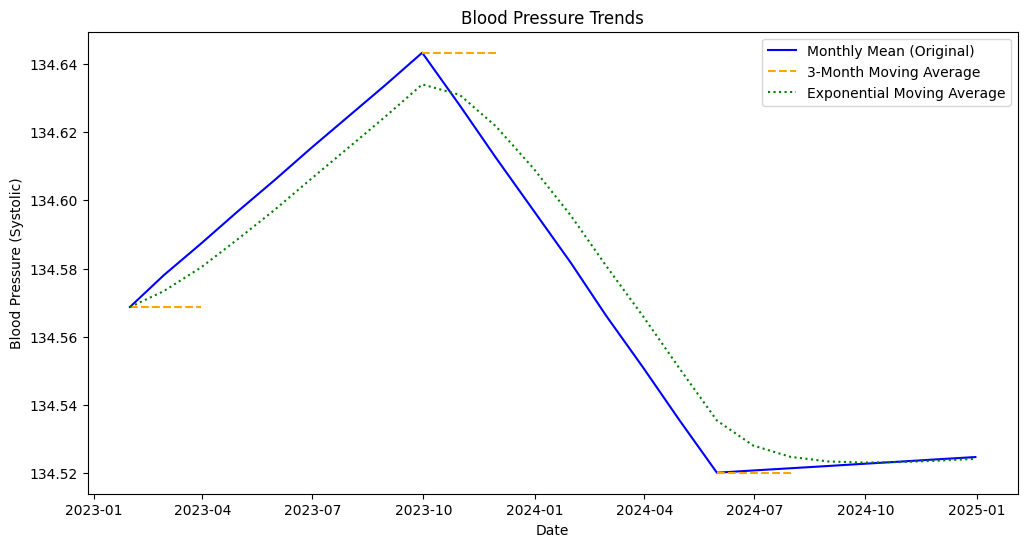

In [6]:
# Resample the data
monthly_data = data['bp_systolic'].resample('ME').mean()

#Calculate 3-Month Moving Averages
monthly_data_ma = monthly_data.rolling(window=3, min_periods=1).mean()

#Handle Missing Data
monthly_data = monthly_data.interpolate()

#Exponential Moving Average 
monthly_data_ewm = monthly_data.ewm(span=3, adjust=False).mean()

#Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Monthly Mean (Original)', color='blue')
plt.plot(monthly_data_ma, label='3-Month Moving Average', color='orange', linestyle='--')
plt.plot(monthly_data_ewm, label='Exponential Moving Average', color='green', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Blood Pressure (Systolic)')
plt.title('Blood Pressure Trends')
plt.legend()
plt.show()

# Statistical Modeling Tasks

#### Analyze factors affecting baseline blood pressure:

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        22:35:11   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

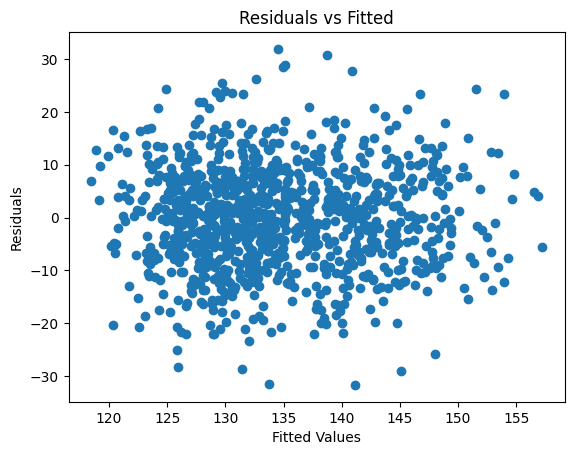

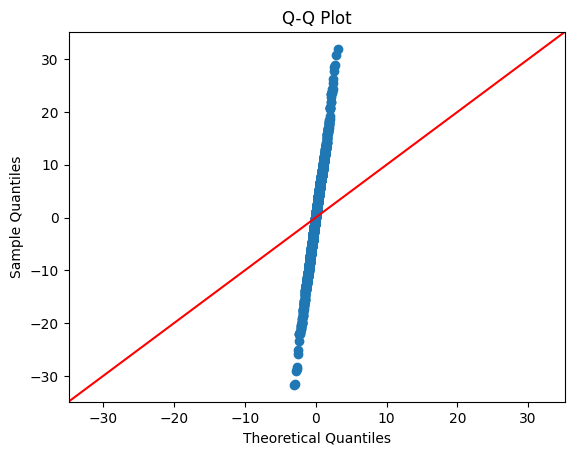

In [ ]:
#Load the Baseline Data with Correct Delimiter
import pandas as pd
baseline_data = pd.read_csv('/Users/kankantingting/08-time-stats-and-ml-kanting6/patient_baseline.csv', delimiter='\t')

#Set up the OLS Regression Model
import statsmodels.api as sm

# Define the target variable and predictor variables
X = baseline_data[['age', 'bmi', 'smoking', 'diabetes']]
y = baseline_data['bp_systolic']

# Add a constant term to the predictor matrix
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Examine Model Results
print(model.summary())

#Visualize by plots
import matplotlib.pyplot as plt
import scipy.stats as stats

# Residuals vs Fitted Plot
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Q-Q Plot
sm.qqplot(model.resid, line='45')
plt.title("Q-Q Plot")
plt.show()

#### Model treatment effectiveness:

Index(['patient_id', 'age', 'sex', 'bmi', 'smoking', 'diabetes', 'bp_systolic',
       'cholesterol', 'heart_rate', 'treatment', 'adherence', 'outcome'],
      dtype='object')
Odds Ratios:
 const        0.122616
age          1.008759
bmi          0.999802
smoking      0.790602
diabetes     0.672122
adherence    6.692442
dtype: float64
Confidence Intervals:
                2.5%      97.5%
const      0.032339   0.464910
age        0.999248   1.018362
bmi        0.972373   1.028004
smoking    0.531695   1.175584
diabetes   0.477048   0.946964
adherence  1.809626  24.750303
Residual Deviance: 1296.4508842795383
Null Deviance: 1334.774434101428


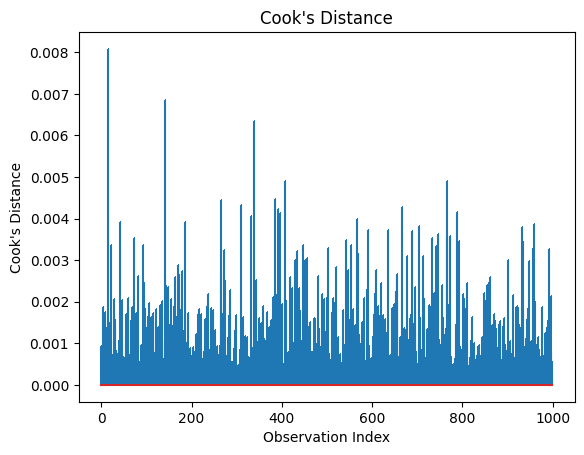

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Load the treatment dataset
patient_treatment = pd.read_csv('/Users/kankantingting/08-time-stats-and-ml-kanting6/patient_treatment.csv', delimiter='\t')

# Check the columns (optional, to verify the dataset structure)
print(patient_treatment.columns)

# Define predictors and target variable (update target to 'outcome')
X = patient_treatment[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y = patient_treatment['outcome']  # 'outcome' as the target variable

# Add constant
X = sm.add_constant(X)

# Fit the GLM with binomial family
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Calculate Odds Ratios and Confidence Intervals
odds_ratios = np.exp(model.params)
conf_int = np.exp(model.conf_int())
conf_int.columns = ['2.5%', '97.5%']
print("Odds Ratios:\n", odds_ratios)
print("Confidence Intervals:\n", conf_int)

# Assess Model Fit
print(f"Residual Deviance: {model.deviance}")
print(f"Null Deviance: {model.null_deviance}")
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Draw diagnostic plot - Cook's Distance
plt.stem(cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()


# Machine Learning Tasks (stretch goal)

#### Build a prediction pipeline:

In [2]:
#Import Required Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load datasets
baseline_df = pd.read_csv('patient_baseline.csv', delimiter='\t')
treatment_df = pd.read_csv('patient_treatment.csv', delimiter='\t')

# Merge datasets on patient_id
data = pd.merge(baseline_df, treatment_df[['patient_id', 'treatment', 'adherence', 'outcome']], on='patient_id', how='inner')

# Check the structure of the merged dataset
print(data.head())

# Define features and target variable
X = data.drop(columns=['patient_id', 'outcome'])  # Drop ID and outcome columns for features
y = data['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define numeric and categorical features
numeric_features = ['age', 'bmi', 'bp_systolic', 'cholesterol', 'heart_rate', 'adherence']
categorical_features = ['sex', 'smoking', 'diabetes', 'treatment']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Build the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced'))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


   patient_id   age  sex   bmi  smoking  diabetes  bp_systolic  cholesterol  \
0           0  57.5    0  25.8        0         0        108.7        257.9   
1           1  47.9    0  23.2        0         0        149.4        155.9   
2           2  59.7    1  29.0        0         0        136.7        220.7   
3           3  72.8    1  34.6        0         1        141.0        205.7   
4           4  46.5    0  17.5        0         0        129.0        186.8   

   heart_rate  treatment  adherence  outcome  
0        79.3          0       0.67        1  
1        75.4          1       0.90        1  
2        85.0          0       0.74        0  
3        78.0          1       0.70        1  
4        95.2          0       0.77        0  
Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.66      0.69       123
           1       0.52      0.58      0.55        77

    accuracy                           0

#### Validate model performance:

fit_time: 0.004
score_time: 0.005
test_accuracy: 0.657
test_precision: 0.552
test_recall: 0.627
test_roc_auc: 0.694
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.72      0.61      0.66       184
           1       0.50      0.62      0.56       116

    accuracy                           0.62       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.64      0.62      0.62       300

Confusion Matrix:
 [[113  71]
 [ 44  72]]
ROC AUC: 0.6674006746626686


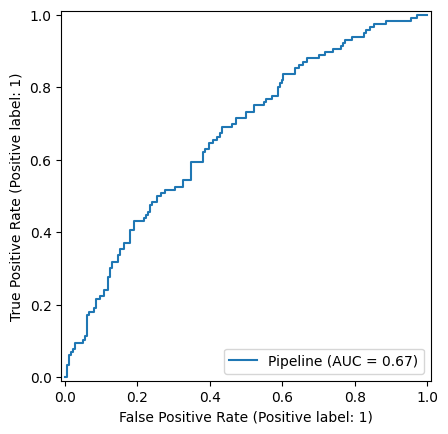

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset (update the file path as needed)
baseline_df = pd.read_csv('patient_baseline.csv', delimiter='\t')
treatment_df = pd.read_csv('patient_treatment.csv', delimiter='\t')

# Merge datasets on patient_id
data = pd.merge(baseline_df, treatment_df[['patient_id', 'treatment', 'adherence', 'outcome']], on='patient_id', how='inner')

# Define features and target variable
X = data.drop(columns=['patient_id', 'outcome'])  # Drop ID and outcome columns for features
y = data['outcome']

# Stratified split for 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

# Define numeric and categorical features
numeric_features = ['age', 'bmi', 'bp_systolic', 'cholesterol', 'heart_rate', 'adherence']
categorical_features = ['sex', 'smoking', 'diabetes', 'treatment']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Build the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced'))
])

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation with multiple scoring metrics
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

# Display cross-validation scores for each metric
for metric in scores:
    print(f"{metric}: {scores[metric].mean():.3f}")

# Train the model on the full training set
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Display classification metrics
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC AUC
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot ROC Curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()
